# Notebook tutorial de redes convolucionales

### Alcance

En este notebook se definira los conceptos teoricos detras de las redes convolucionales y se definira paso a paso un ejercicio que usa esta técnica para identificar en fotografias aereas si hay cactus en la zona o no. El codigo de este notebook es en PyTorch.

### Introducción

En este notebook entrenaremos una red convolucional que sea capaz de reconocer si en una foto hay un cactus o no, este dataset es parte de la competencia de Kaggle Aerial Cactus Identification del 2015, patrocinada por varios entes universitarios como un estudio complementario para determinar el nivel de desertificación en varios desiertos de Mexico, parte de un estudio para identificar el impacto del calentamiento global.

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


#### Importando las librerias nesesarias para trabajar.

In [2]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models 
from PIL import Image 
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
plt.style.use("ggplot")
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torch.utils.data.sampler import SubsetRandomSampler
import pandas as pd
import numpy as np 
import sys
import os
import torch.optim as optim

ModuleNotFoundError: No module named 'torch'

In [3]:
sys.path.append("/content/gdrive/My Drive/dl-pytorch")

In [4]:
import plot_helpers as plt

In [5]:
%cd "/content/gdrive/My Drive/cactus/train"
dataset = pd.read_csv('./train.csv')

/content/gdrive/My Drive/cactus/train


### Inspeccionando el dataset

Como todo problema es importante entender la naturaleza del mismo, para este el objetivo es simple reconocer si en una foto aerea, hay o no cactus.

El tamaño de cada iamgen es de 34x34 pixeles a color, esto significa que el tensor que ve el computador es de 34x34x3.

Si imprimimos el tamaño del dataset observaremos que las 2/3 partes de las fotografias tienen cactus, mientras que 1/3 no tiene.

![train_test_size.png](attachment:train_test_size.png)

Si un dataset tiene casi el 90% de la información para entrenamiento, esto impactara los resultados. Esto se conoce como clases asimetricas, aca se recomienda usar data_augmentation. Para dominar esta técnica es muy importante conocer la libreria opencv de python, más información aquí: https://opencv.org/

---

#### Preparando la data

Para el manejo de imagenes en pytorch, es una buena practica escribir una clase DataSet que herede de la libreria original de Torch, se modifica solo los metodos len y get_item para que funcionen con imagenes.

Para esta clase se usa la función mpimg de matplotlib para manejar la imagen y en las transformadas se usa el metodo ToPILImage para convertir la imagen a un array de numpy, más información en la documentación de OpenCv.

In [6]:
class CACTUSDataset(Dataset):
  def __init__(self, ds, base_dir, transform=None):
    self.ds = ds
    self.base_dir = base_dir
    self.transform = transform

  def __len__(self):
    return len(self.ds)

  def __getitem__(self, idx):
    img_name = self.ds.id[idx]
    target = self.ds.has_cactus[idx]
    img_path = os.path.join(self.base_dir, img_name)
    image = mpimg.imread(img_path)
    if self.transform:
      image = self.transform(image)
    return image, target

### Redes convolucionales vs redes multi-capa(fully conected)

En el tutorial anterior vimos como las redes multicapa son poderosas por si solas,logrando una presición del 90% sin mucho esfuerzo. Resulta que en el ambito profesional donde se maneja información más compleja, por si solas no son tan utiles, la raiz principal de este problema es que el input de estos algoritmos es un vector plano que contenga toda la información pertinente. En el problema anterior fue sencillo solucionar el problema dado que el dataset de MNIST digit son vecotores planos con toda la información pertinente de la imagen. En el mundo real el input va a ser una imagen a color o en el mejor de los casos una imagen a blanco y negro. Esto se traduce en el mejor de los casos un tensor de 32x32x1 y en el peor un tensor de 32x32x3, esto asumiendo que la imagen es pequeña, usualmente tampoco es así. Ambos casos tienen como input algo muy diferentes a un vector plano.

La solución más sencilla seria aplanar el tensor, sin embargo al hacer esto se pierde información importante para el analisis, los contrastes de luz y sombras que estan embebidos en los arreglos de pixeles, es acá donde entran las redes convolucionales.

A través de la operación matematica de convolución se le aplican filtros a la imagen que permiten conservar estos contrastes en un valor numerico que conserva la información y si se puede aplanar.

#### Entendiendo las redes convolucionales

Las redes convolucionales usan tres tipos de capas para operar:

* Capas Convolucionales
* Capas de Pooling
* Capas profundas (fully conected)

Vamos a revisar cada una en detalle:

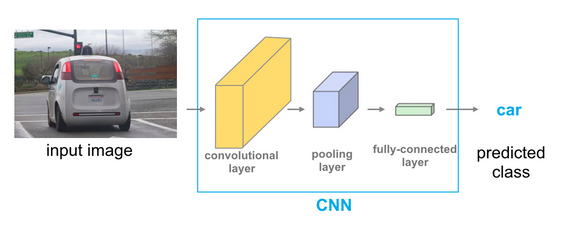

##### La capa convolucional

Para entender el concepto de capa convolucional primero se hace nesesario entender el concepto de filtros, En especifico los llamados high-pass filters.

Para detectar cambios de intensidad dentro de una imagen se hace nesesario crear filtros especificos que buscan grupos de pixeles y reaccionan a patrones alternos de luz y sombra en la imagen. Estos filtros producen una salida que muestra los bordes de objetos y de diferentes texturas. Aća la diferencia con las redes fully connected que a medida que amuentan sus capas aumentan también su abastracción de bordes, las convolvuciones permiten incluir las texturas a la ecuación. 

Estos filtros se construyen de acuerdo a un tamaño, conocido como tamaño de ventana. que no es nada más que una matriz como esta:

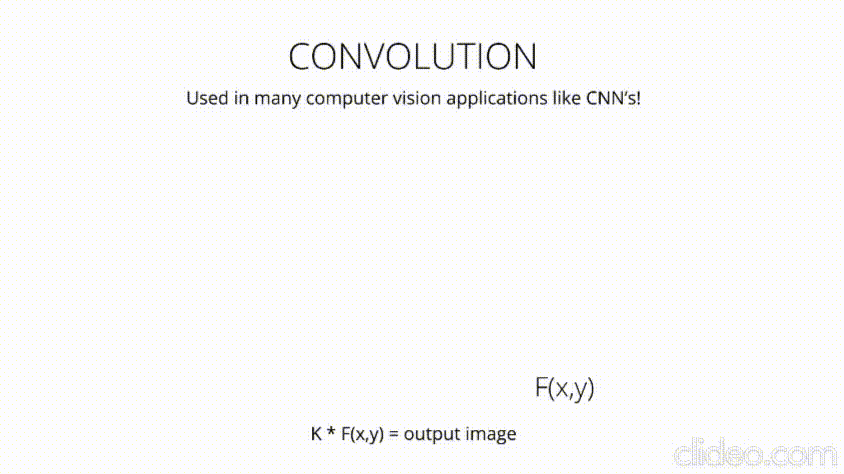

Estas ventanas tienen un tamaño usualmente de 3x3 que le ayuda a la red convolucional a identificar patrones en una imagen. Estos filtros a su vez pueden ser modificados para obtener diferentes filtros en la salida, es comun que en una red convolucional haya una gran cantidad de filtros, la agrupación de estos se conoce como kernel.

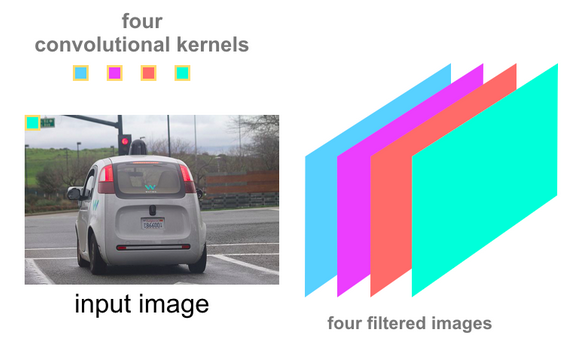

En la figura mostrada 4 diferentes filtros producen cuatro imagenes filtradas, cuando apilamos estas imagenes formamos una red convolucional de prifundidad igual a cuatro.

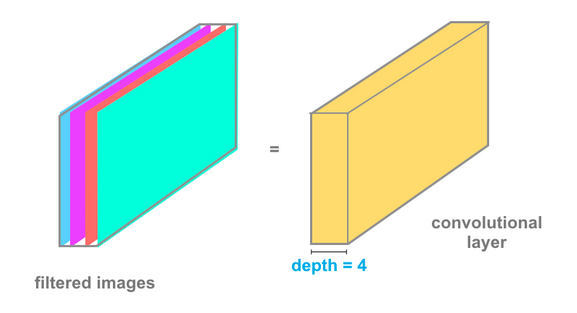

La profundidad de cada capa arreglada de manera consecutiva produce una red capaz de identificar patrones y caracteristicas increiblemente complejas, de la misma forma en la que nuestro cerebro interpreta lo que vemos.

Hay otros dos conceptos secundarios al definir una convolución, que sin embargo bien usados pueden mejorar o empeorar una red.

El primero es stride, el stride es el paso del filtro por la imagen, como valor default se usa 1, esto se traduce en un filtro que avanza pixel por pixel. Si se cambiase a dos el kernel avanzaria cada dos pixeles.

El segundo concepto es el de padding, si has trabajado en diseño frontend web tal vez te suene familiar la idea. En redes convolucionales es el siguiente: los filtros usualmente son matrices cuadradas, sin embargo al operar en una matriz no cuadrada se presentan problemas en la operación de convolución, para estos casos que son la gran mayoria, se aplica un relleno alrededor de la imagen, este relleno es el padding, el valor default es 1,aunque también se puede trabajar con 0.

##### Max Pooling

Bien ya tenemos una red capaz de detectar los patrones y caracteristicas, que nuestra red neuronal multiple por si sola no hubise podido. Sin embargo si procesamos esta información como esta nuestro algoritmo pude demorarse eternidades en procesarse o no tener memoria para lograrlo. Es acá dondeentran las capas de pooling o Max Pool.

La operación de Pooling es usada en las redes convolucionales para hacer la detección de ciertas caracteristicas que podrián considerarse constantes en escala y cambios de orientación. Otra manera de entender este concepto es ver a la operación como una manera de generalizar información compleja sobre bajos niveles.

Similar a la convolución, la operación consiste de una ventana de tamaño fijo que recorre la imagen y dentro de la ventana cálcula un valor de acuerdo a la metrica que está establecida para esta operación. Como resultado obtiene un nuevo tensor.

Cuando la metrica consiste en encontrar el máximo valor de la ventana, la operación se conoce como Max Pooling. También existe Average Pooling que determina el valor promedio. Como alternativa a la operación de pooling existe un concepto llamado redes de capsula, en la siguiente imagen se muestra la operación de max pool.

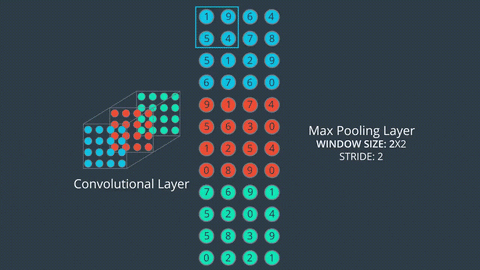

Cuando combinamos las capas de Pooling con las capas convolucionales reducimos la dimensión de la información, solucionando el problema de capacidad computacional y garantizando que la información procesada sea la de mayor importancia minimzando la perdida de la misma.

Asi nuestro modelo se transforma en algo así:

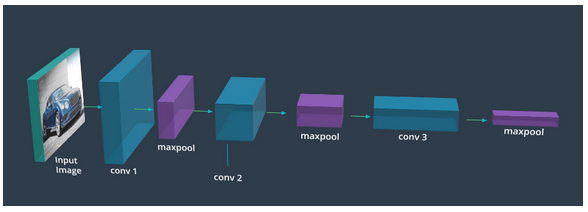

##### Capas profundas

Las capas profundas son las que ya conocemos y es la ultima pieza de una red Convolucional. Así la arquitectura de nuestra red sería algo así:

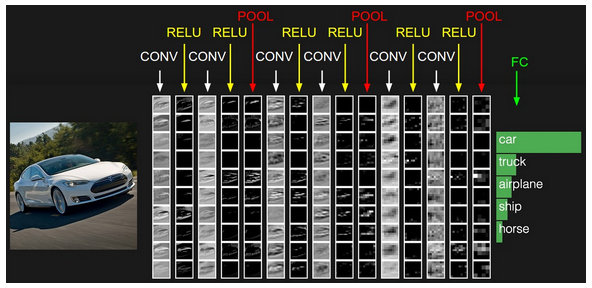

Una vez ya entendemos como funciona una red convolucional es hora de definir su arquitectura.

---

### Definiendo la arquitectura

A la hora de definir la arquitectura de una red convolucional es importante definir primero las capas de convolución, en esta sección explicare como se definio la primera capa, pero en el codigo están los detalles de las otras.

Nuestras imagenes están compuestas de tres canales (RGB) esto se traduce en un tensor de profundidad 3. Este es el valor de entrada de nuestra primera capa, 3 canales. Como salida de esta capa se selecciona 16 canales, esto usando las ecuaciones explicadas en clase. Como regla del dedo gordo se podria decir que este numero corresponde a la mitad del largo de la imagen, pero esto solo aplica para matrices cuadradas y las reglas del dedo gordo siempre son guias nunca reglas fijas.

Como parametros de la ecuación se selecciona un kernel de 3, con un stride de 1 y un padding de 1. Las siguientes capas conservan ests valores. Solo cambia los canales de entrada y salida.

Para las capas de pooling se define el tamaño del stride, el default es 2.

Finalmentese define la arquitectura de la red neuronal fully connected, para este caso dos capas ocultas, una capa de entrada y una de salida.

In [1]:
class Net(nn.Module):
  def __init__(self, num_channels):
    super(Net, self).__init__()

    self.num_channels = num_channels
    # Convolutional Layer (input 32x32x3 image tensor)
    self.conv1 = nn.Conv2d(3, self.num_channels, 3, stride=1, padding=1)
    self.bn1 = nn.BatchNorm2d(self.num_channels)
    # Convolutional Layer (input 16x16x16 image tensor)
    self.conv2 = nn.Conv2d(self.num_channels, self.num_channels*2, 3, stride=1, padding=1)
    self.bn2 = nn.BatchNorm2d(self.num_channels*2)
    # Convolutional Layer (input 8x8x32 image tensor)
    self.conv3 = nn.Conv2d(self.num_channels*2, self.num_channels*4, 3, stride=1, padding=1)
    self.bn3 = nn.BatchNorm2d(self.num_channels*4)
    # Convolutional Layer (input 4*4*64 image tensor)
    self.conv4 = nn.Conv2d(self.num_channels*4, self.num_channels*8, 3, stride=1, padding=1)
    self.bn4 = nn.BatchNorm2d(self.num_channels*8)
    # Linear Fully-Connected Layer 1 (input 2*2*128 image tensor)
    self.fc1 = nn.Linear(self.num_channels*8*2*2, self.num_channels*8*2*2)
    self.fcbn1 = nn.BatchNorm1d(self.num_channels*8*2*2)
    self.fc2 = nn.Linear(self.num_channels*8*2*2, 2)

  def forward(self, x):
    x = self.bn1(self.conv1(x)) 
    x = F.relu(F.max_pool2d(x, 2)) 
    x = self.bn2(self.conv2(x)) 
    x = F.relu(F.max_pool2d(x, 2)) 
    x = self.bn3(self.conv3(x))
    x = F.relu(F.max_pool2d(x, 2))
    x = self.bn4(self.conv4(x))
    x = F.relu(F.max_pool2d(x, 2))

    #flatten
    x = x.view(-1, self.num_channels*8*2*2)

    #fc
    x = F.relu(self.fcbn1(self.fc1(x)))
    x = F.dropout(x, p = 0.8, training=True)
    x = self.fc2(x)

    #Sigmoid
    #x = nn.Sigmoid(x)

    return x

NameError: name 'nn' is not defined

In [32]:
def train_and_evaluate(model, optimizer, loss_fn, dataloaders, device, num_epoch=30, lr=0.0019):
  for g in optimizer.param_groups:
    g['lr'] = lr

  for epoch in range(num_epoch):
    print('Epoch {}/{}'.format(epoch+1, num_epoch))
    print('-'*64)

    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()

      running_loss = RunningMetric()
      running_acc = RunningMetric()

      for inputs, targets in dataloaders[phase]:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()

        with torch.set_grad_enabled(phase == 'train'):
          outputs = net(inputs)
          _, preds = torch.max(outputs, 1)

          loss = loss_fn(outputs, targets)
          
          if phase == 'train':
            loss.backward()
            optimizer.step()

        batch_size = inputs.size()[0]
        running_loss.update(loss.item()*batch_size,
                            batch_size)
        running_acc.update(torch.sum(preds==targets).float(), batch_size)
      
      print('Loss: {:.4f}, Acc: {:.4f}'.format(running_loss(), running_acc()))

In [9]:
class RunningMetric():
  def __init__(self):
    self.S = 0
    self.N = 0

  def update(self, val, size):
    self.S += val
    self.N += size

  def __call__(self):
    return self.S/float(self.N)

In [10]:
transform = transforms.Compose(
    [
      transforms.ToPILImage(),
      transforms.RandomHorizontalFlip(),
      transforms.RandomRotation(10),
      transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

In [11]:
cactus_train = CACTUSDataset(dataset,"./train", transform=transform)

In [12]:
len(cactus_train)

17500

In [13]:
# Percentage of training set to use as validation
valid_size = 0.2

# obtain training indices that will be used for validation
num_train = len(cactus_train)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# Create Samplers
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = DataLoader(cactus_train, batch_size=64, sampler=train_sampler)
val_loader = DataLoader(cactus_train, batch_size=64, sampler=valid_sampler)

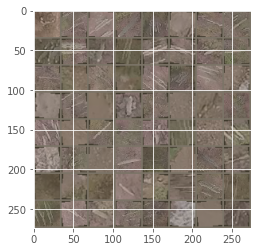

tensor([1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0,
        0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1,
        0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1])


In [16]:
for inputs, targets in train_loader:
  out = make_grid(inputs)
  plt.imshow(out)
  print(targets)
  break

In [17]:
device = torch.device('cuda') 

In [30]:
net = Net(16).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)

In [22]:
datalaoders = {'train': train_loader,
               'val': val_loader}

In [33]:
train_and_evaluate(net, optimizer, loss_fn, datalaoders, device)

Epoch 1/30
----------------------------------------------------------------
Loss: 0.1077, Acc: 0.9589
Loss: 0.1308, Acc: 0.9583
Epoch 2/30
----------------------------------------------------------------
Loss: 0.0687, Acc: 0.9769
Loss: 0.0526, Acc: 0.9809
Epoch 3/30
----------------------------------------------------------------
Loss: 0.0633, Acc: 0.9782
Loss: 0.0401, Acc: 0.9857
Epoch 4/30
----------------------------------------------------------------
Loss: 0.0491, Acc: 0.9828
Loss: 0.0387, Acc: 0.9863
Epoch 5/30
----------------------------------------------------------------
Loss: 0.0458, Acc: 0.9843
Loss: 0.0351, Acc: 0.9863
Epoch 6/30
----------------------------------------------------------------
Loss: 0.0376, Acc: 0.9866
Loss: 0.0373, Acc: 0.9874
Epoch 7/30
----------------------------------------------------------------
Loss: 0.0336, Acc: 0.9879
Loss: 0.0317, Acc: 0.9897
Epoch 8/30
----------------------------------------------------------------
Loss: 0.0345, Acc: 0.9886
Lo

In [34]:
submit = pd.read_csv('../sample_submission.csv')
test_data = CACTUSDataset(submit,"../test/test", transform=transform)
test_loader = DataLoader(test_data, batch_size=20)

In [35]:
predict = []

with torch.no_grad():
  net.eval()
  for inputs, _ in test_loader:
     inputs, _ = inputs.to(device), _.to(device)
     output = net(inputs)
     res = torch.exp(output)
     top_p, top_class = res.topk(1, dim = 1)

     for prediction in top_class:
       predict.append(prediction.item())
    
submit['has_cactus'] = predict
submit.to_csv('submission.csv', index=False)